In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt

import glob, sys, os
from matplotlib.patches import Rectangle
import csv
from scipy.optimize import curve_fit
import scipy

sys.path.append("/mnt/home/jgoldberg/python_modules/py_mesa_reader/")
import mesa_reader as mr

import pickle 

import warnings

mu = 0.645
Mu = 0.645
Rgas = 8.31447*10**7 / mu
Grav = 6.6743e-8
sigma = 5.6704e-5
RSUN = 6.9634e10
MSUN = 1.99e33
LSUN = 3.839e33
year = 3.156e7
kb = 1.3807e-16
arad = 7.5646e-15

In [2]:
# plt.style.use('mesa.mplstyle')
plt.ion()
%matplotlib inline

In [3]:
def make_grid(dirstarts, lindex=-1, print_stuff=False):
    MBgrid = {}
    MBgrid['Mej'] = np.asarray([])
    MBgrid['Menv'] = np.asarray([])    
    MBgrid['L'] = np.asarray([])
    MBgrid['Mzams'] = np.asarray([])
    MBgrid['R'] = np.asarray([])
    MBgrid['Teff'] = np.asarray([])
    MBgrid['eta'] = np.asarray([])
    MBgrid['labels'] = np.array([])
    MBgrid['MHe'] = np.asarray([])    
    MBgrid['MHtot'] = np.asarray([])    
    MBgrid['Tsurf'] = np.asarray([])
    MBgrid['Rsurf'] = np.asarray([])
    MBgrid['mod_name'] = []

    for dirstart in dirstarts:
        for file in os.listdir(dirstart):
            cond = "_history.data" in file
            cond2 = "_at_cc.mod" in file
            
            if cond:
                if print_stuff:
                    print(file)
                modname = dirstart+'/'+file
                data = mr.MesaData(file_name = modname)
                if '10M' in file[:4]:
                    zams_mass=10.0
                    eta_model = float(file[24:27])
                else: 
                    zams_mass = float(file[:4])
                    eta_model = float(file[26:29])
                #     print(zams_mass)
                Mej = data.star_mass[-1] - data.m_center[-1]
            #     print(total_mass)
                luminosity = data.L[lindex]
                R = data.R[0]
                Teff = data.Teff[0]
                MHe = data.he_core_mass[0]
                Menv = data.star_mass[-1] - data.he_core_mass[0]
                MHtot = data.total_mass_h1[-1]
                MBgrid['Menv'] = np.append(MBgrid['Menv'], Menv)
                MBgrid['MHe'] = np.append(MBgrid['MHe'], MHe)
                MBgrid['MHtot'] = np.append(MBgrid['MHtot'], MHtot)
                MBgrid['Mej'] = np.append(MBgrid['Mej'], Mej)
                MBgrid['L'] = np.append(MBgrid['L'], luminosity)
                MBgrid['R'] = np.append(MBgrid['R'], R)
                MBgrid['Teff'] = np.append(MBgrid['Teff'], Teff)
                MBgrid['Mzams'] = np.append(MBgrid['Mzams'], zams_mass)
                MBgrid['eta'] = np.append(MBgrid['eta'], eta_model)
                MBgrid['labels'] = np.append(MBgrid['labels'], file.replace('z0.02_','').replace('_vvc_0.','rot').replace('alpha_', 'a').replace('eta_','e').replace('M_','').replace('f0.0','f0'))

            if cond2:
                modname = dirstart+'/'+file
                data = mr.MesaData(modname)
                rs = np.exp(data.lnR)/RSUN
                model=file
                masses = np.cumsum((data.dq)[::-1])[::-1]*data.header('M/Msun')
                MBgrid['Tsurf'] = np.append(MBgrid['Tsurf'], np.exp(data.lnT[0]))
                MBgrid['Rsurf'] = np.append(MBgrid['Rsurf'], np.exp(data.lnR[0])/RSUN)
                MBgrid['mod_name'] = np.append(MBgrid['mod_name'], str(model))
    return MBgrid

In [5]:
### Only run the code below if you're trying to populate the grid!

# dirstarts = ['/mnt/home/jgoldberg/ceph/Projects/MassiveStarGrid/nonrotating_modgrid_knot/',
#              '/mnt/home/jgoldberg/ceph/Projects/MassiveStarGrid/rotating_modgrid_knot/']
# MBgrid = make_grid(dirstarts, print_stuff=True)

### Store the grid as a pickle file that python can read
# with open('MBgrid.pkl', 'wb') as f:
#     pickle.dump(MBgrid, f)
        

In [6]:
# Load from MBgrid.pkl

with open('MBgrid.pkl', 'rb') as f:
    MBgrid = pickle.load(f)    

In [7]:
print(MBgrid['R'])

[725.76337035 669.00312934 675.04288465 ... 886.69592192 893.34603471
 849.63912149]


logL 42.206
MNi 0.049999999999999996
tpt 117.20000000000006


<IPython.core.display.Javascript object>


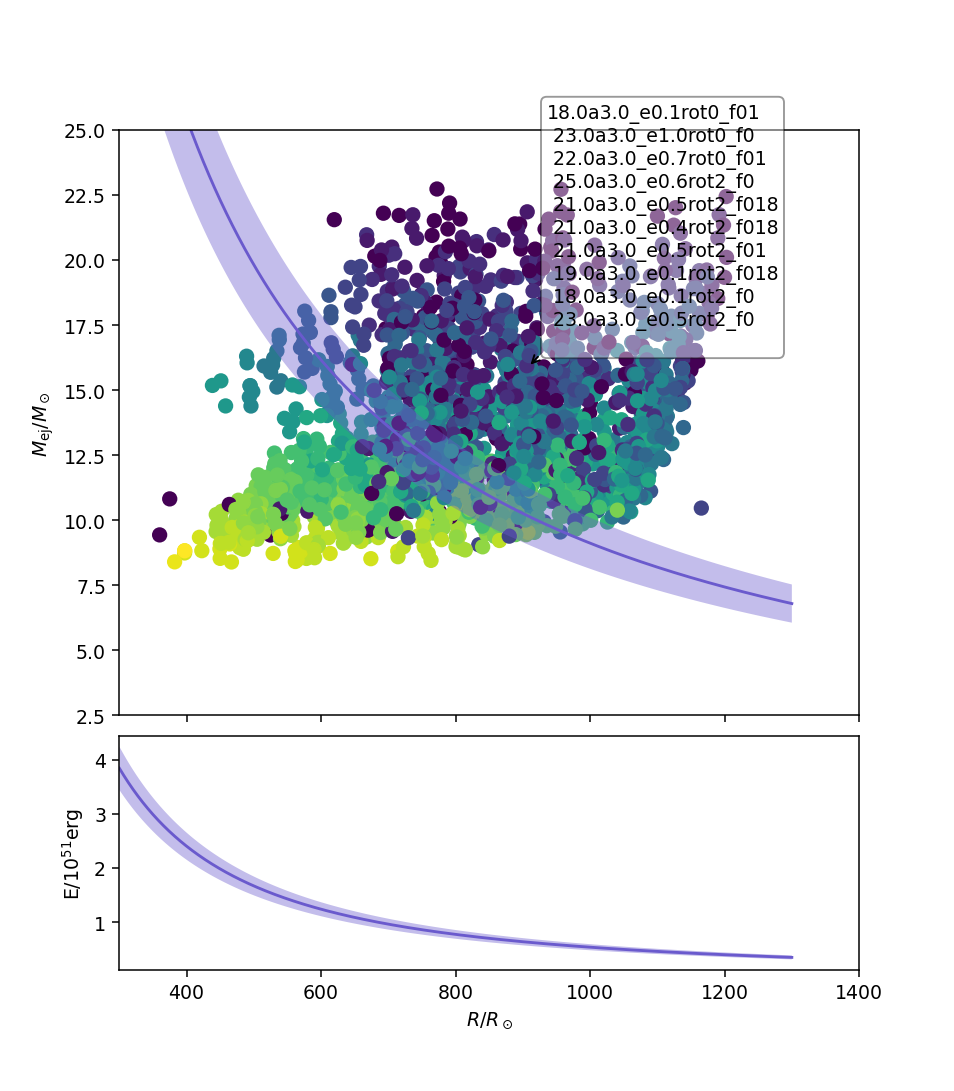

In [8]:
%matplotlib notebook

# Get from .mod file at core collapse when v -> 10000 km s^-1
Rmin = 300
Rmax = 1300
Merrorbar = 0.108 # Modeling uncertainty from Goldberg+2019 paper
Eerrorbar = 0.104 # Modeling uncertainty from Goldberg+2019 paper

#### # For 2017eaw
logL = 42.206
logMNi = np.log10(0.05)
logt = np.log10(117.2)

#####For 2004A

# logL = 41.933
# logMNi = np.log10(0.042)
# logt = np.log10(123.997)

##### For 09ib
# logL = 41.6689
# logMNi = np.log10(0.046) 
# logt = np.log10(139.757)

##### For 09ib, corrected
# logL = 41.6689 + np.log10(1.17**2)
# logMNi = np.log10(0.046*1.17**2) 
# logt = np.log10(139.757)

#### For 17gmr
# logt = np.log10(94.45)
# logL = 42.57
# logMNi = np.log10(0.13)

### For 18zd at 6.63 Mpc

# logL = np.log10(4.14203793375575e+41)
# logt = np.log10(125.4)
# logMNi = np.log10(0.0041)

# ### For standard candle 18zd

# logL = np.log10(4.14203793375575e+41)+2*np.log10(9.64/6.63)
# logt = np.log10(125.4)
# logMNi = np.log10(0.0086)

###### For 2004et

# logt = np.log10(123.07)
# logL = 42.2666
# logMNi = np.log10(0.063)



print('logL', logL)
print('MNi', 10**logMNi)
print('tpt', 10**logt)

# Point "M" to MBgrid for cleaner 
M = MBgrid

mpl.rcParams.update(mpl.rcParamsDefault)
names = [l.replace('_history.data', '') + '\n' for l in M['labels']]#np.array([str(m)+'\n' for m in M['Mzams']])



# Start the plot

fig, axes = plt.subplots(2, figsize = (7,8), sharex = True,gridspec_kw = {'height_ratios':[2.5, 1]},)

# Set axes and axis labels
ax = axes[0]
ax2 = axes[1]

ax.set_ylabel(r'$M_{\rm ej}/M_\odot$')

ax2.set_ylabel(r'E/$10^{51}$erg')

axes[-1].set_xlabel(r'$R/R_\odot$')
ax.set_xlim(Rmin, Rmax+100) # Just for a bit of extra space to read labels

# Scatter the model grid R vs Mej 
sc = ax.scatter(M['R'],M['Mej'], cmap = 'viridis_r', c = M['Mzams'], s=50)#, vmin=4.2, vmax=5.5


logEfoe_prediction_tpt = lambda logRfh: -0.7283 + 2.148*(logL-42) - 0.280*logMNi + 2.091*(logt-2)-1.632*logRfh
logM10_prediction_tpt = lambda logRfh: -0.947 + 1.474*(logL-42) - 0.518*logMNi + 3.867*(logt-2)-1.120*logRfh
logRaxis = np.linspace(np.log10(Rmin/500), np.log10(Rmax/500), 1000)
xaxis = 500*10**logRaxis

annot = ax.annotate("", xy=(0,0), xytext=(10,10),textcoords="offset points",
                    bbox=dict(boxstyle="round", fc="w"),
                    arrowprops=dict(arrowstyle="->"))
annot.set_visible(False)
def update_annot(ind):

    pos = sc.get_offsets()[ind["ind"][0]]
    annot.xy = pos
    text = "{}".format(#" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
#     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    annot.get_bbox_patch().set_alpha(0.4)
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = sc.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()
fig.canvas.mpl_connect("motion_notify_event", hover)

p1y = 10*10**logM10_prediction_tpt(logRaxis)
p2y = 10**logEfoe_prediction_tpt(logRaxis)
p1, = ax.plot(xaxis, p1y, color = 'slateblue', label = r'Using $t_{\rm p}$ scalings')
p2, = ax2.plot(xaxis, p2y, color = 'slateblue')

ax.fill_between(xaxis, (1-Merrorbar)*p1y, (1+Merrorbar)*p1y, facecolor = 'slateblue', alpha = 0.4)
ax2.fill_between(xaxis, (1-Eerrorbar)*p2y, (1+Eerrorbar)*p2y, facecolor = 'slateblue', alpha = 0.4)
ax.set_ylim(2.5,25)

fig.subplots_adjust(hspace=0.05)
plt.show()
